In [2]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import os
from pathlib import Path
from cai_robustness_metrics.metrics.calibration import ECE
from scipy.special import softmax
sns.set(color_codes=True)
%matplotlib inline

WP = "params.quantization/weight_precision"
AP = "params.quantization/activation_precision"
paths = ['q_motion_blur_1_preds.csv',  'q_preds.csv', 'q_brightness_1_preds.csv', 'q_motion_blur_2_preds.csv', 'q_jpeg_compression_2_preds.csv', 'q_jpeg_compression_1_preds.csv', 'q_contrast_2_preds.csv', 'q_contrast_1_preds.csv']

In [7]:
NAME = 'LENET'
EXP_ID = '7'
FILE = 'q_preds.csv'
TYPE = 'ECE' # ECE, CONFIDENCE

mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")
df_runs = mlflow.search_runs(
    experiment_ids=EXP_ID,
    filter_string="tags.type = 'pruning + quantization'",
    output_format="pandas"
)

runs = df_runs[df_runs[AP] == '7']

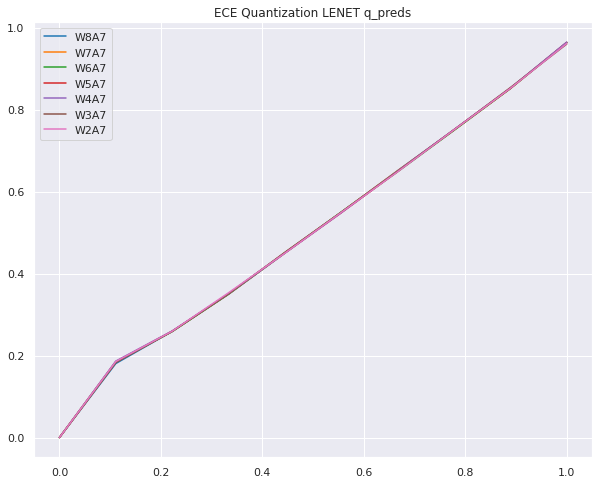

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")
plt.title(f"{TYPE} Quantization {NAME} {FILE.removesuffix('.csv')}")

for i in range(len(runs)):
    run = runs.iloc[i]
    path = run["params.csv_path"]
    ap = run[AP]
    wp = run[WP]
    df = pd.read_csv(path + f"/{FILE}")

    ece = ECE(num_bins=10)

    preds = df.iloc[:,0:10].to_numpy()
    preds = softmax(preds, axis=1)
    targs = df['targets'].to_numpy()
    ece.update(preds, targs)

    if TYPE == 'ECE':
        sns.lineplot(x=np.linspace(0, 1, 10), y=ece.confidences_avg, label=f"W{wp}A{ap}", markers=True)
    elif TYPE == 'CONFIDENCE':
        sns.lineplot(x=np.linspace(0, 1, 10), y=ece.confidences_sum / 10000, label=f"W{wp}A{ap}")

#plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'g')
#plt.savefig(f"/home/k.schwienbacher/quantization-robustness/data/ece/{NAME}-{FILE.removesuffix('.csv')}A{ap}W{wp}.jpg")


In [4]:
FP_FILE = "preds.csv"
df_runs_fp = mlflow.search_runs(
    experiment_ids=EXP_ID,
    filter_string="tags.stage = 'eval'",
    output_format="pandas"
)

runs = df_runs_fp[df_runs_fp[AP] == None]

In [5]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette("tab10")
plt.title(f"{TYPE} {NAME} {FP_FILE.removesuffix('.csv')}")

run = df_runs_fp[df_runs_fp["tags.type"] != "quantization"].iloc[0]
path = run["params.csv_path"]
df = pd.read_csv(path + f"/{FP_FILE}")

ece = ECE(num_bins=10)

preds = df.iloc[:,0:10].to_numpy()
preds = softmax(preds, axis=1)
targs = df['targets'].to_numpy()
ece.update(preds, targs)

if TYPE == 'ECE':
    sns.lineplot(x=np.linspace(0, 1, 10), y=ece.confidences_avg, label=f"32fp", markers=True)
elif TYPE == 'CONFIDENCE':
    sns.lineplot(x=np.linspace(0, 1, 10), y=ece.confidences_sum / 10000, label=f"32fp")

IndexError: single positional indexer is out-of-bounds